Showing gain control can create anticipative signals
by using both HMM and LPOU signal

created by ckc on Sept 9, 2021

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import savgol_filter
%matplotlib inline
from random import gauss

In [72]:
# OU signal generator

def OU_Gen(G_OU,D_OU,xmax,xmin,T,dt):
    const = 2.12**2.0
# time is in second

    nstep=int(T/dt)


# generate the stochastic sequence in x
    x = np.zeros(nstep)
    x[0] = 0.0
    for i in range(nstep-1):
        x[i+1] = (1-dt*G_OU/const)*x[i]+sqrt(dt*D_OU)*gauss(0,1)
    maxval = np.max(x)
    minval = np.min(x)
    ratio = 1./(maxval-minval)
    for i in range(nstep):
        x[i] = xmin+(x[i]-minval)*ratio*(xmax-xmin)
    return x

In [73]:
# HMM signal generator

def HMM_Gen(G_HMM,D_HMM,xmax,xmin,T,dt):
# time is in second

    nstep=int(T/dt)

# HMM model parameters
#    G_HMM = 4; 
#    D_HMM = 2700000;     #dynamical range
    omega =G_HMM/2.12;   # omega = G/(2w)=1.06; follow Bialek's overdamped dynamics/ 2015PNAS

# generate the stochastic sequence in x
    x = np.zeros(nstep)
    v = np.zeros(nstep)
    x[0] = 0.0
    v[0] = 0.0
    for i in range(1,nstep):
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = (1-G_HMM*dt)*v[i-1]-omega**2*x[i-1]*dt + gauss(0,1)*np.sqrt(D_HMM*dt)
    maxval = np.max(x)
    minval = np.min(x)
    ratio = 1./(maxval-minval)
    for i in range(nstep):
        x[i] = xmin+(x[i]-minval)*ratio*(xmax-xmin)
    return x

In [74]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))


In [75]:
# generate the HMM signal

nstep = 20000*5
dt = 0.02
G_HMM = 1.
D_HMM = 2.7e6;     #dynamical range
xmin = 0.0
xmax = 1.0
#dt = 0.05    # sec
T = nstep*dt
tt = np.zeros(nstep)
for i in range(nstep):
    tt[i] = dt*i
G = 0.1
x = HMM_Gen(G,D_HMM,xmax,xmin,T,dt)

In [76]:
#AGC
y = np.zeros(nstep)
gain =np.ones(nstep)
delay = 200
for i in range(delay,nstep):
    gain[i] = 1/(1+y[i-delay]**2)
    y[i]= gain[i]*x[i]

In [77]:
yf = fft(y-np.mean(y))
yyf = np.convolve(yf,yf,'same')

(49900.0, 50100.0)

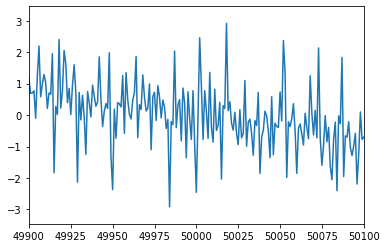

In [56]:
# plt.plot(yyf.real)
# plt.plot(yyf.imag)
# plt.plot(np.abs(yyf))
plt.plot(np.angle(yyf))

plt.xlim([49900,50100])

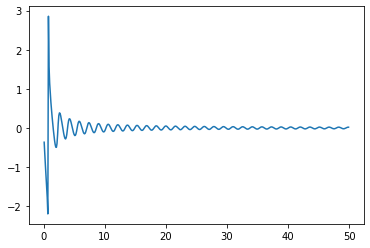

In [57]:
dOmega = 0.1
omega = np.arange(dOmega,50,dOmega)
H = 1/(1+np.exp(1j*omega*delay*dt)/omega)#/(omega*1j)
G = np.abs(H)
Phi = np.angle(H)
delta = -np.append(np.diff(Phi),0)/dOmega
plt.plot(omega,Phi)

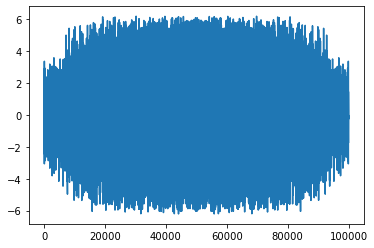

In [58]:
yf = fft(y)
xf = fft(x)
H = xf/yf
Phi = np.angle(H)
# Phi = np.nd
delta = -np.diff(Phi)
plt.plot(delta)
# plt.xlim([0,500])

(0.0, 2000.0)

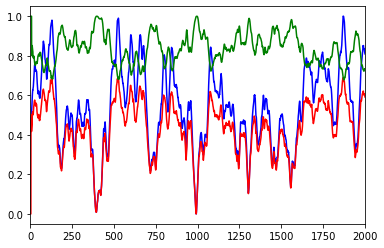

In [78]:
plt.plot(tt,x,'b')
plt.plot(tt,y,'r')
plt.plot(tt,gain,'g')
plt.xlim([0,2000])

In [80]:
dms = range(-499,500)

In [81]:
mi_xx = [mi_quick(x,x,d) for d in dms] 
mi_yy = [mi_quick(y,y,d) for d in dms]
mi_xy = [mi_quick(x,y,d) for d in dms]
mi_xg = [mi_quick(x,gain,d) for d in dms]

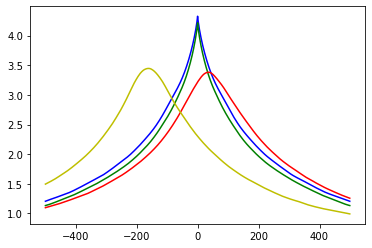

In [82]:
plt.plot(dms,mi_xx,'b')
plt.plot(dms,mi_yy,'g')
plt.plot(dms,mi_xy,'r')
plt.plot(dms,mi_xg,'y')

In [83]:
dms[np.argmax(mi_xy)]*dt

0.72

In [85]:
# xAutoConvolve = np.convolve( x-np.mean(x), x-np.mean(x), 'same' )
xAutoCorrelate = np.correlate( x-np.mean(x), x-np.mean(x), 'same' )
xyCorrelate = np.correlate( y-np.mean(y), y-np.mean(y), 'same' )

(45000.0, 55000.0)

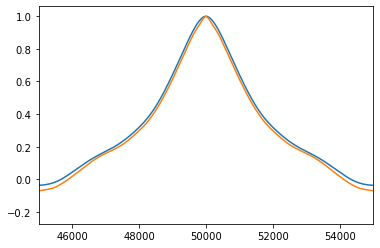

In [90]:
# plt.plot(xAutoConvolve)
plt.plot( xAutoCorrelate/max(xAutoCorrelate) )
plt.plot( xyCorrelate/max(xyCorrelate) )
plt.xlim(45000,55000)

In [65]:
# LPOU generation taken from Chou's coe
alpha = 2
beta =  1
K = 20
g = 10

Tot=300
dt=0.001
T=np.arange(dt,Tot,dt)
tau=0.6
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering
fc=0.5
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
z = signal.filtfilt(b, a, L)
z = z[0:nstep]

In [66]:
#AGC
w = np.zeros(nstep)
gain =np.ones(nstep)
delay = int(10/0.05)
delay = 300
for i in range(delay,nstep):
    gain[i] = 1/(1+w[i-delay]**2)
    w[i]= gain[i]*z[i]

(0.0, 2000.0)

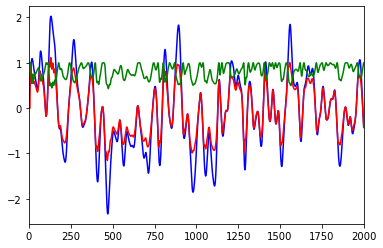

In [67]:
plt.plot(tt,z,'b')
plt.plot(tt,w,'r')
plt.plot(tt,gain,'g')
plt.xlim([0,2000])

In [68]:
dms = range(-499,500)
mi_zz = [mi_quick(z,z,d) for d in dms] 
mi_ww = [mi_quick(w,w,d) for d in dms]
mi_zw = [mi_quick(z,w,d) for d in dms]
mi_zg = [mi_quick(z,gain,d) for d in dms]

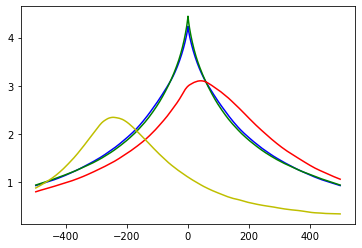

In [69]:
plt.plot(dms,mi_zz,'b')
plt.plot(dms,mi_ww,'g')
plt.plot(dms,mi_zw,'r')
plt.plot(dms,mi_zg,'y')

In [70]:
delay

300